In [50]:
import logging
import numpy as np
from docplex.mp.model_reader import ModelReader
import math
import numpy as np
from docplex.mp.basic import Expr
from docplex.mp.model import Model
from docplex.mp.solution import SolveSolution
from docplex.util.status import JobSolveStatus
import cplex.callbacks as cpx_cb
from docplex.mp.relax_linear import LinearRelaxer



# Convertng an quadratic non-convex constraint to a linear constraint

Generally speaking, if $u$ and $p$ are variables in a mathematical program, and you want to deal with their product $z= xy$ you will end up having a quadratic problem (which may create problems with convexity if the quadratic terms appear in constraints). There is a special case, though, when at least one of  $u$ and $p$ is binary, and when the other variable is bounded. Under those assumptions, the product can be linearized.

Let $u$ be binary and let $L ≤ p ≤ M$ where $L$ and $M$ are bounds known in advance. Introduce a new variable $z$. (Programming note: Regardless of whether $p$ is real-valued, integer-valued or binary, $z$ can be treated as real-valued.) Add the following four constraints:

### $z ≤ Mu$  ... (1)

### $z ≥ Lu$ ... (2)

### $z ≤ p−L(1−u)$ ... (3)

### $z ≥ p − M(1−u)$ ... (4)

Consider the first case $u=0$, which means the product $z=uy$ should be zero. The first pair of inequalities says $0 ≤ y ≤ 0$, forcing $z=0$.The second pair of inequalities says $p-M ≤ z ≤ p-L$, and $z=0$ satisfies those inequalities.

Now consider the second case $u=1$, which means the product $z=y$ should be zero. The first pair of inequalities becomes $L ≤ p ≤ M$, , which is satisfied by $z=p$. The second pair says $p ≤ z ≤ p$, forcing $z=y$ as desired.

in our case u, p are both binary. Therefore M = 1 and L =0

### $z ≤ u$  ... (1)

### $z ≥ 0 $ ... (2)

### $z ≤ p$ ... (3)

### $z ≥ p +u −1$ ... (4)




In [51]:
from docplex.mp.model import Model
opt_model = Model(name="MIP Model")

Nc= 50 # Nc is the number of seconds

Dist=150 # Distance to travel

tolerance = 2 # Tolerance in distance travelled

delta_v=1 # Rate of acceleration/deceleration set to 1

vmax=4 # Max speed of a TGV in France (in m/s)

alpha=0.05 # Regenerative braking efficiency

"""
We define two binary variables for two bits. 
When x=0 and y=0 then constant velocity
When x=1 and y=0 then acceleration
When x=0 and y=1 then breaking
"""

x={}
for i in range(0, Nc):
    x[i]= opt_model.binary_var(name=f"x_{i}")

y={}
for i in range(0, Nc):
    y[i]= opt_model.binary_var(name=f"y_{i}")

z={}
for i in range(0, Nc):
    z[i]= opt_model.binary_var(name=f"z_{i}")
    

objective = opt_model.linear_expr()

## objective is the hamiltonian/energy value we want to minimize
## Energy:
'''for i in range(0, Nc):
    objective += (delta_v**2) * x[i] - alpha*(delta_v**2)*y[i]
    #objective += (delta_v**2)*x[i]'''

for i in range(0,Nc):
    objective += delta_v**2 * (Nc-i)*(x[i]-y[i])
    sub_objective = opt_model.linear_expr()
    for j in range(0,i):
        sub_objective += delta_v**2 * - 0.001 * (x[j]-y[j])
    objective += sub_objective**2
    
opt_model.minimize(objective)

    
## Constraint 1: (simultaneous braking/acceleration)
"""
Constraint 1: (simultaneous braking/acceleration for each time slice)
which means 
for i in range(0, Nc):
    opt_model.add_constraint(x[i] * y[i] == 0 ) 
This will lead to quadratic non-convex constraint. So We linearize it with the above prescription

"""
# opt_model.add_constraint(opt_model.sum(x[i] * y[i] for i in range(1, Nc)) == 0 , "No_simultaneous_braking_or_acceleration_constraint")

for i in range(0, Nc):
    opt_model.add_constraint(z[i] <= x[i] , f"z_u_d_{i}") 

for i in range(0, Nc):
    opt_model.add_constraint(z[i] <= y[i], f"z_p_d_{i}")
        
for i in range(0, Nc):
    opt_model.add_constraint(z[i] >= x[i]+ y[i] -1 , f"z_u_p_d_{i}") 
    
opt_model.add_constraint(opt_model.sum(z[i] for i in range(0, Nc)) == 0 , "No_simultaneous_braking_or_acceleration_constraint")

### This is another way to write the No simultaneous braking or acceleration constraint also
# for i in range(0, Nc):
#     opt_model.add_constraint(z[i] == 0 , f"z_u_p_d_0{i}") 


"""
Constraint 2: (Total Distance constraints)
"""

distance = opt_model.linear_expr()
velocity = 0
for i in range(0, Nc):
    velocity = velocity + delta_v*(x[i]-y[i])
    distance += velocity
opt_model.add_constraint(distance <= Dist+tolerance, "Max_Distance_constraint")
opt_model.add_constraint(distance >= Dist-tolerance, "Min_Distance_constraint")

### old distance constraints for conparison
# opt_model.add_constraint(opt_model.sum(((Nc-i)*delta_v*y[i]-(Nc-i)*delta_v*x[i]) for i in range(0, Nc)) == Dist , "Distance constraint")
# opt_model.add_constraint(opt_model.sum((i*delta_v*y[i]+i*delta_v*x[i]+ ) for i in range(0, Nc)) == Dist , "Distance constraint")

"""
Constraint 3: (Net-Zero contraint)

"""
opt_model.add_constraint(opt_model.sum((y[i]-x[i]) for i in range(0, Nc)) == 0 , "Net_Zero_constraint")

"""
Constraint 4: (Maximum Speed)

"""
opt_model.add_constraint(opt_model.sum((delta_v*x[i]) for i in range(0, Nc)) <= vmax , "Maximum_Speed_constraint")

#Constraint 5: (Positive Speed)
for i in range(Nc):
    opt_model.add_constraint(opt_model.sum((x[i]-y[i]) for i in range(0, i)) >= 0 , "Positive_Speed_constraint")

#Constraint 6: (Must leave immediately)

opt_model.add_constraint(x[0]==1, "Must leave immediately constraint")
    

#### Print the optimization model

opt_model.print_information() 

print(opt_model.prettyprint())               


Model: MIP Model
 - number of variables: 150
   - binary=150, integer=0, continuous=0
 - number of constraints: 206
   - linear=206
 - parameters: defaults
 - objective: minimize quadratic
 - problem type is: MIQP
// This file has been generated by DOcplex
// model name is: MIP Model
// single vars section
dvar bool x_0;
dvar bool x_1;
dvar bool x_2;
dvar bool x_3;
dvar bool x_4;
dvar bool x_5;
dvar bool x_6;
dvar bool x_7;
dvar bool x_8;
dvar bool x_9;
dvar bool x_10;
dvar bool x_11;
dvar bool x_12;
dvar bool x_13;
dvar bool x_14;
dvar bool x_15;
dvar bool x_16;
dvar bool x_17;
dvar bool x_18;
dvar bool x_19;
dvar bool x_20;
dvar bool x_21;
dvar bool x_22;
dvar bool x_23;
dvar bool x_24;
dvar bool x_25;
dvar bool x_26;
dvar bool x_27;
dvar bool x_28;
dvar bool x_29;
dvar bool x_30;
dvar bool x_31;
dvar bool x_32;
dvar bool x_33;
dvar bool x_34;
dvar bool x_35;
dvar bool x_36;
dvar bool x_37;
dvar bool x_38;
dvar bool x_39;
dvar bool x_40;
dvar bool x_41;
dvar bool x_42;
dvar bool x_43

In [52]:
result = opt_model.solve(log_output=True) #(log_output=self.solver_config.cplex_log)
x_value=[]
for l in range(0, Nc):
    x_value.append(result.get_value(f"x_{l}"))
    print(f"x_{l} =" , result.get_value(f"x_{l}")  )

y_value=[]
for l in range(0, Nc):
    y_value.append(result.get_value(f"y_{l}"))
    print(f"y_{l} =" , result.get_value(f"y_{l}")  )
    

print("Binary Variables X" , x_value, "Binary Variables y" , y_value, "Objective value", result.objective_value )


Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve eliminated 106 rows and 52 columns.
MIP Presolve added 9120 rows and 4560 columns.
MIP Presolve modified 198 coefficients.
Reduced MIP has 9220 rows, 4658 columns, and 21025 nonzeros.
Reduced MIP has 4658 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (3.38 ticks)
Found incumbent of value 148.074054 after 0.02 sec. (13.70 ticks)
Probing fixed 48 vars, tightened 0 bounds.
Probing time = 0.02 sec. (22.13 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve eliminated 2353 rows and 49 columns.
Reduced MIP has 6867 rows, 4609 columns, and 18574 nonzeros.
Reduced MIP has 4609 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (26.21 ticks)
Classifier predicts products in MIQP should be linearized.
Probing time = 0.01 sec. (4.45 ticks)
Clique table members: 13972.
MIP emphasis: balance 

## Visualisation of results

In [53]:
def distance(x, y, Nc):
    velocity = 0
    vel = [0]
    dist = [0]
    dist_tot= 0
    for i in range(0, Nc):
        velocity = velocity + delta_v*(x[i]-y[i])
        vel.append(velocity)
        dist_tot += velocity
        dist.append(dist_tot)
    return dist,vel

In [54]:
time= np.arange(Nc+1)
distn, velo = distance(x_value, y_value, Nc)

/tmp/ipykernel_17373/2590230446.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


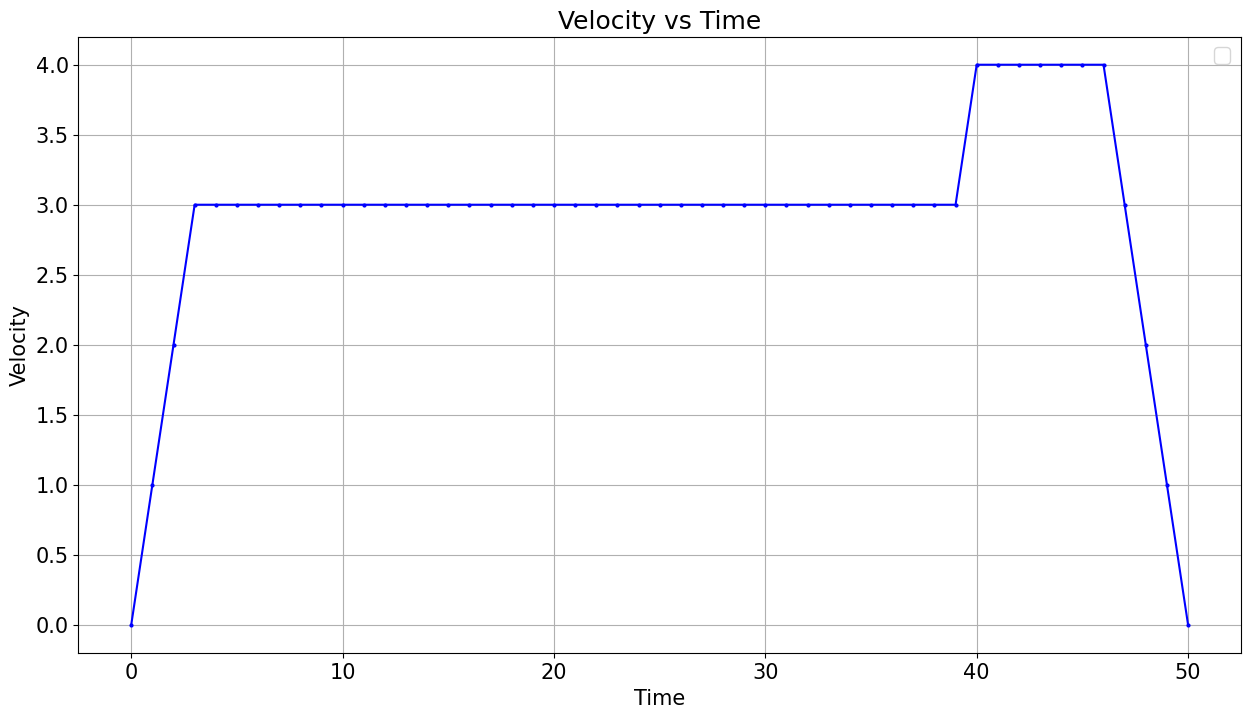

2.9019607843137254


In [55]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))

matplotlib.rcParams.update({"font.size": 15})

# plt.step(time, velo, c='b', marker="o", markersize=1, linestyle='-')#, label='label') 
plt.plot(time, velo, c='b', marker="o", markersize=2, linestyle='-')#, label='label)

plt.xlabel('Time')
plt.ylabel('Velocity')
plt.title("Velocity vs Time")
plt.grid(axis='x')
plt.grid(axis='y')
plt.legend()
plt.show()
print(np.average(velo))

/tmp/ipykernel_17373/1235688432.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


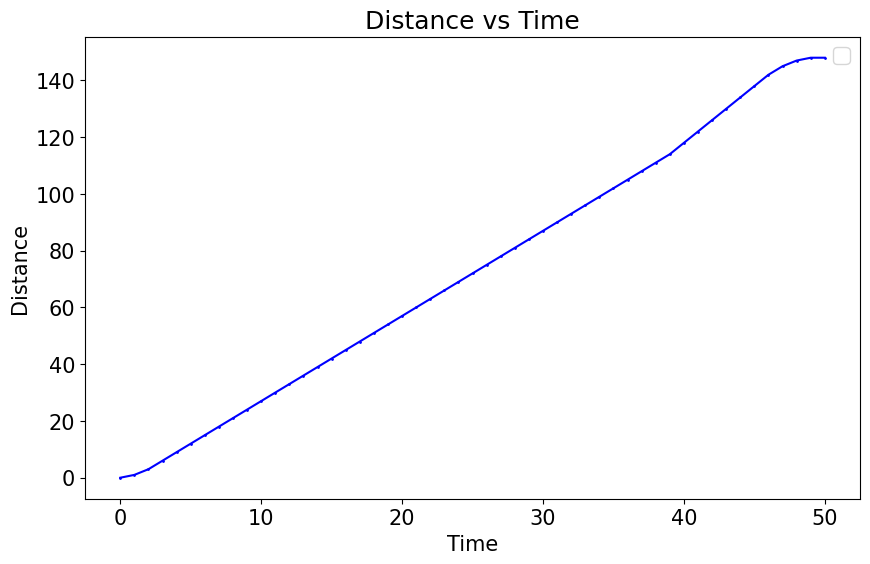

In [56]:
import matplotlib
plt.figure(figsize=(10,6))

matplotlib.rcParams.update({"font.size": 15})

plt.plot(time, distn, c='b', marker="o", markersize=1, linestyle='-')#, label='label')
plt.xlabel('Time')
plt.ylabel('Distance')
plt.title("Distance vs Time")
plt.legend()
plt.show()